<a href="https://colab.research.google.com/github/sera0911/Dacon/blob/main/%EA%B5%AC%EB%82%B4%EC%8B%9D%EB%8B%B9_%EC%8B%9D%EC%88%98_%EC%9D%B8%EC%9B%90_%EC%98%88%EC%B8%A1_AI/LGBM%EB%AA%A8%EB%8D%B8_%EC%A0%81%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##식수인원 수치데이터로만 예측해보기

In [1]:
#모듈 불러오기

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

import warnings
warnings.filterwarnings(action='ignore')

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [2]:
#데이터 불러오기

train = pd.read_csv('/content/drive/MyDrive/구내식당AI/train.csv')
test = pd.read_csv('/content/drive/MyDrive/구내식당AI/test.csv')

In [3]:
#데이터확인하기
train.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0


In [4]:
#중식, 석식계가 없는 테스트 데이터 확인하기
test.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,금,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가자수          50 non-null     int64  
 4   본사출장자수          50 non-null     int64  
 5   본사시간외근무명령서승인건수  50 non-null     int64  
 6   현본사소속재택근무자수     50 non-null     float64
 7   조식메뉴            50 non-null     object 
 8   중식메뉴            50 non-null     object 
 9   석식메뉴            50 non-null     object 
dtypes: float64(1), int64(4), object(5)
memory usage: 4.0+ KB


##데이터 정제

1. 조식, 중식, 석식메뉴는 버리기 (drop)
2. 일자, 요일은 라벨 인코딩 (숫자형으로 변환)

In [7]:
#조식, 중식, 석식메뉴 drop

drops = ['조식메뉴', '중식메뉴', '석식메뉴']

train = train.drop(drops, axis=1)
test = test.drop(drops, axis=1)

In [8]:
#정제 데이터 확인
train.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,1017.0,573.0


In [9]:
#일자, 요일은 라벨 인코딩 (숫자형으로 변환)

train['월'] = pd.DatetimeIndex(train['일자']).month  #일자에서 달만 인덱스해서 넣어준다
test['월'] = pd.DatetimeIndex(test['일자']).month

train['일'] = pd.DatetimeIndex(train['일자']).day  #일자에서 일만 인덱스해서 넣어준다
test['일'] = pd.DatetimeIndex(test['일자']).day

In [10]:
weekday = {   #요일을 라벨을 붙여서 매핑해주기
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}

train['요일'] = train['요일'].map(weekday)
test['요일'] = test['요일'].map(weekday)

In [11]:
#데이터 확인
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,월,일
0,2016-02-01,1,2601,50,150,238,0.0,1039.0,331.0,2,1
1,2016-02-02,2,2601,50,173,319,0.0,867.0,560.0,2,2
2,2016-02-03,3,2601,56,180,111,0.0,1017.0,573.0,2,3
3,2016-02-04,4,2601,104,220,355,0.0,978.0,525.0,2,4
4,2016-02-05,5,2601,278,181,34,0.0,925.0,330.0,2,5


## 데이터 정제

- 휴가자, 재택근무자는 중식/석식에 참여하지 않을 것이므로 본사정원수에서 차감한다.

- 즉, 본사정원수 - 휴가자 - 재택근무자

- 식사참여율 = 식사계 / 식사가능자수

In [12]:
#식사가능자수 구하기

train['식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

In [13]:
#식사 참여율 구하기

train['중식참여율'] = train['중식계'] / train['식사가능자수']
train['석식참여율'] = train['석식계'] / train['식사가능자수']

In [14]:
#최종 전처리 데이터 정리(필요한 칼럼만 데이터로 사용)

features = ['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']
labels = ['중식계',	'석식계', '중식참여율', '석식참여율']

train = train[features+labels]
test = test[features]

In [15]:
train.head()

,월,일,요일,식사가능자수,본사출장자수,본사시간외근무명령서승인건수,중식계,석식계,중식참여율,석식참여율
0,2,1,1,2551.0,150,238,1039.0,331.0,0.407291,0.129753
1,2,2,2,2551.0,173,319,867.0,560.0,0.339867,0.219522
2,2,3,3,2545.0,180,111,1017.0,573.0,0.399607,0.225147
3,2,4,4,2497.0,220,355,978.0,525.0,0.391670,0.210252
4,2,5,5,2323.0,181,34,925.0,330.0,0.398192,0.142058


In [16]:
test.head()

,월,일,요일,식사가능자수,본사출장자수,본사시간외근무명령서승인건수
0,1,27,3,2537.0,182,5
1,1,28,4,2531.0,212,409
2,1,29,5,2419.0,249,0
3,2,1,1,2494.0,154,538
4,2,2,2,2548.0,186,455


##EDA, 시각화, 상관관계분석


#### 1. 히트맵

In [17]:
#중식, 석식계에 대한 컬럼들에 상관계수 표현하기

train.corr()[['중식계', '석식계']]

,중식계,석식계
월,-0.154664,-0.127142
일,-0.097392,-0.185565
요일,-0.731563,-0.312112
식사가능자수,0.151029,0.118615
본사출장자수,-0.512680,-0.188164
본사시간외근무명령서승인건수,0.535611,0.571168
중식계,1.000000,0.508287
석식계,0.508287,1.000000
중식참여율,0.957156,0.475360
석식참여율,0.479768,0.973722


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


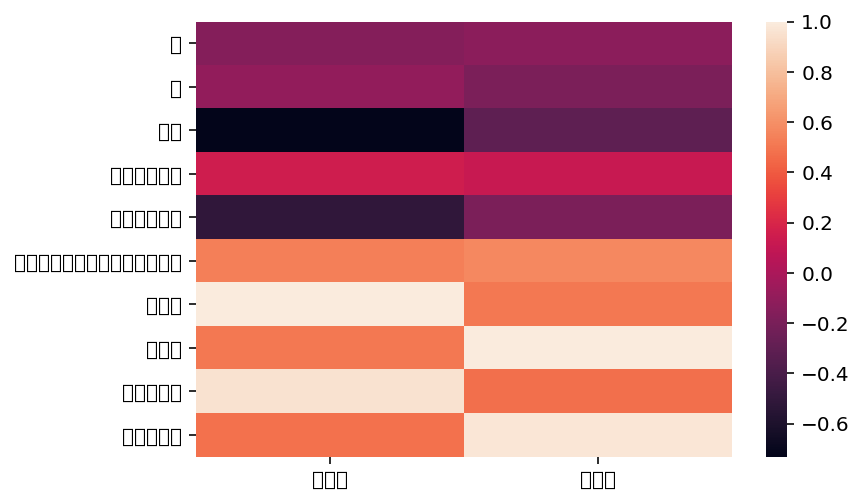

In [18]:
#히트맵으로 표현하기

sns.heatmap(train.corr()[['중식계', '석식계']]);

상관관계 분석 결과

중식에 대해선

1. 요일
2. 본사시간외근무명령서승인건수
3. 본사출장자수

석식에 대해선

1. 본사시간외근무명령서승인건수
2. 요일
3. 본사출장자수

In [19]:
#새롭게 구한 중,석식 참여율에 대해서 상관계수 파악하기

train.corr()[['중식참여율', '석식참여율']]

,중식참여율,석식참여율
월,-0.166198,-0.139499
일,-0.100648,-0.186355
요일,-0.697276,-0.284943
식사가능자수,-0.133553,-0.097914
본사출장자수,-0.618408,-0.267198
본사시간외근무명령서승인건수,0.473097,0.518348
중식계,0.957156,0.479768
석식계,0.475360,0.973722
중식참여율,1.000000,0.511255
석식참여율,0.511255,1.000000


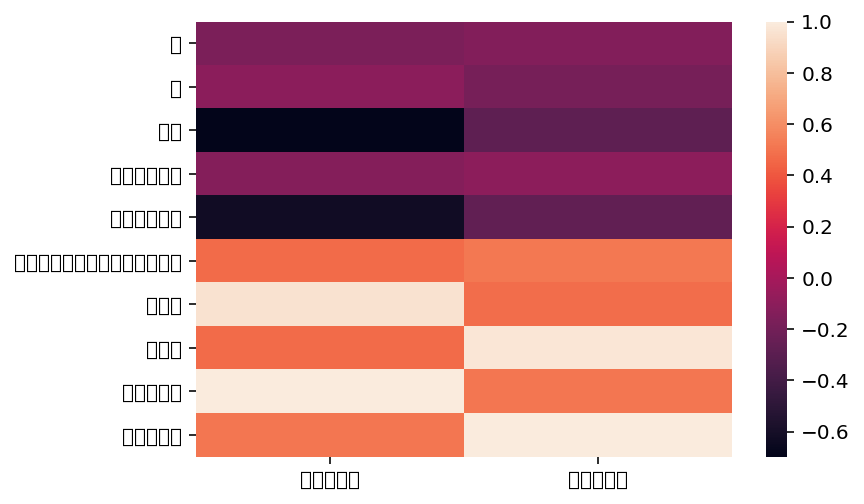

In [20]:
#히트맵으로 나타내기

sns.heatmap(train.corr()[['중식참여율', '석식참여율']])

히트맵으로 표현한 결과, 위에 중식계, 석식계와 결과가 크게 다르지 않은 걸 확인할 수 있다

In [21]:
#계수에 따라 정렬하기

train.corr()['중식참여율'].sort_values()

요일               -0.697276
본사출장자수           -0.618408
월                -0.166198
식사가능자수           -0.133553
일                -0.100648
본사시간외근무명령서승인건수    0.473097
석식계               0.475360
석식참여율             0.511255
중식계               0.957156
중식참여율             1.000000
Name: 중식참여율, dtype: float64

In [22]:
train.corr()['석식참여율'].sort_values()

요일               -0.284943
본사출장자수           -0.267198
일                -0.186355
월                -0.139499
식사가능자수           -0.097914
중식계               0.479768
중식참여율             0.511255
본사시간외근무명령서승인건수    0.518348
석식계               0.973722
석식참여율             1.000000
Name: 석식참여율, dtype: float64

#### 2. 라인그래프


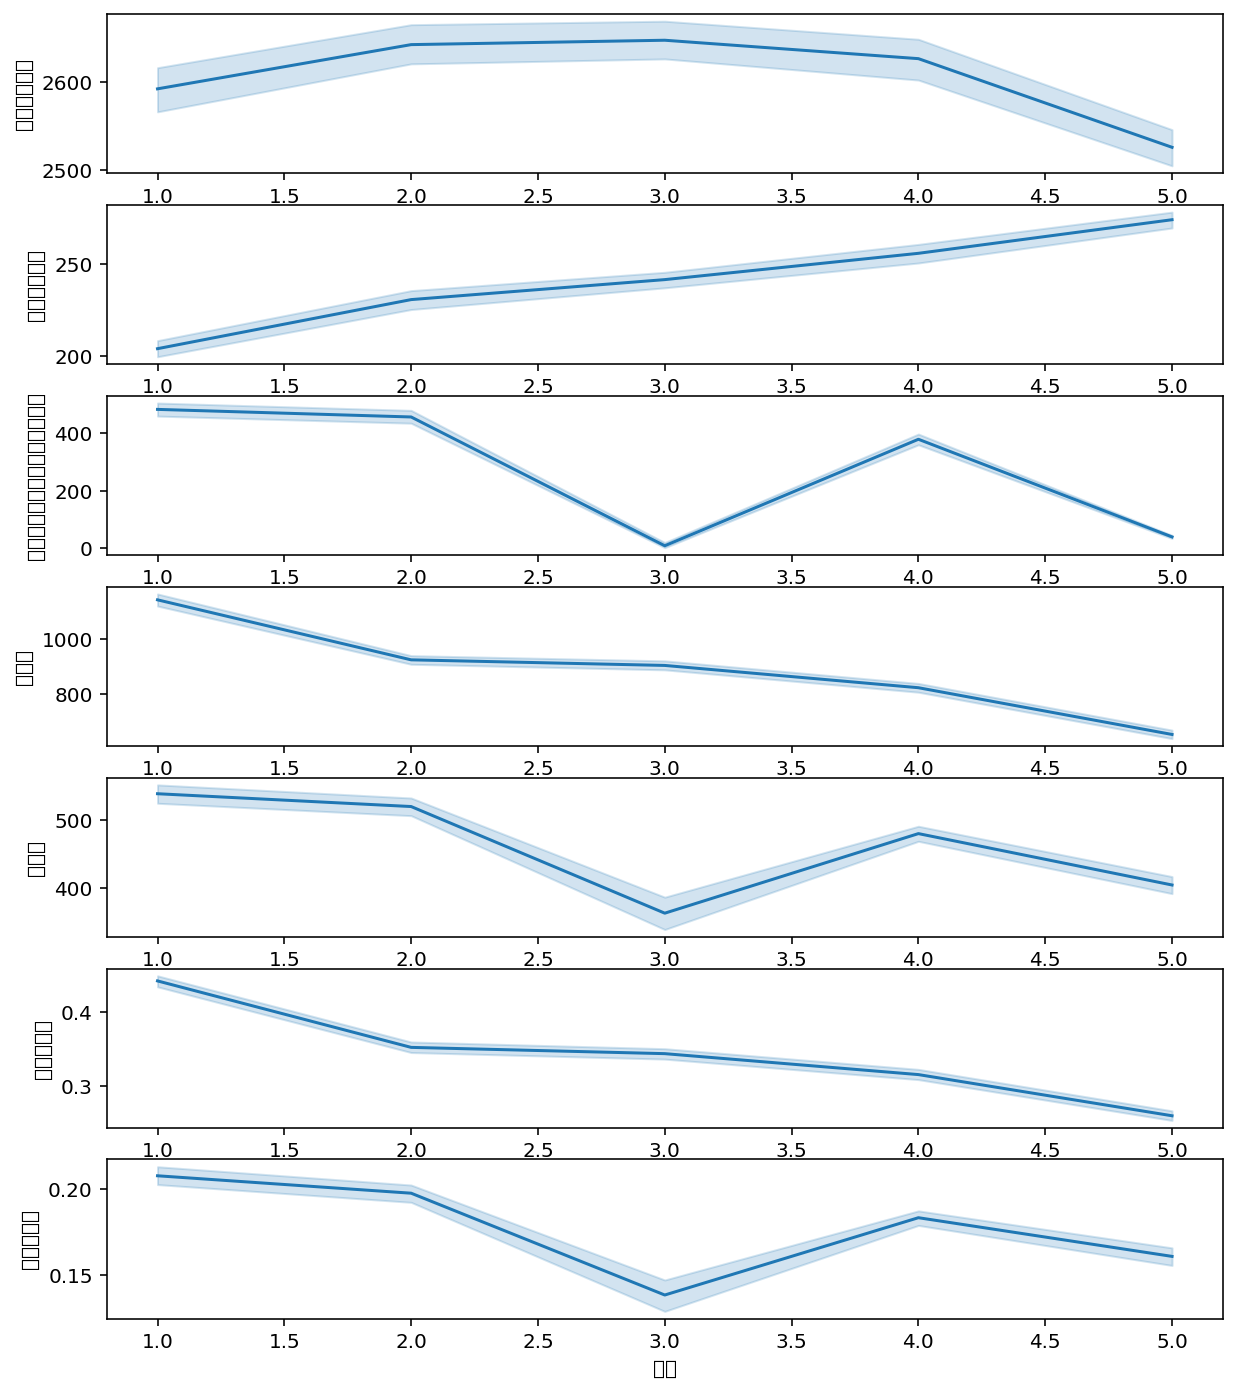

In [23]:
# 요일을 중심으로 그래프 그리기

#그래프 사이즈 설정
fig, ax = plt.subplots(7)
fig.set_size_inches(10,12)

#요일을 x에 놓고 7가지 컬럼에 대하여 수치를 그래프로 나타내기
sns.lineplot(data=train, x='요일', y='식사가능자수', ax=ax[0])
sns.lineplot(data=train, x='요일', y='본사출장자수', ax=ax[1])
sns.lineplot(data=train, x='요일', y='본사시간외근무명령서승인건수', ax=ax[2])
sns.lineplot(data=train, x='요일', y='중식계', ax=ax[3])
sns.lineplot(data=train, x='요일', y='석식계', ax=ax[4])
sns.lineplot(data=train, x='요일', y='중식참여율', ax=ax[5])
sns.lineplot(data=train, x='요일', y='석식참여율', ax=ax[6])

요일별 데이터에서  

- 중식계는 본사출장자수와 반비례 관계,
- 석식계는 본사시간외근무명령서승인건수와 정비례 관계,

로 밀접해 보임.

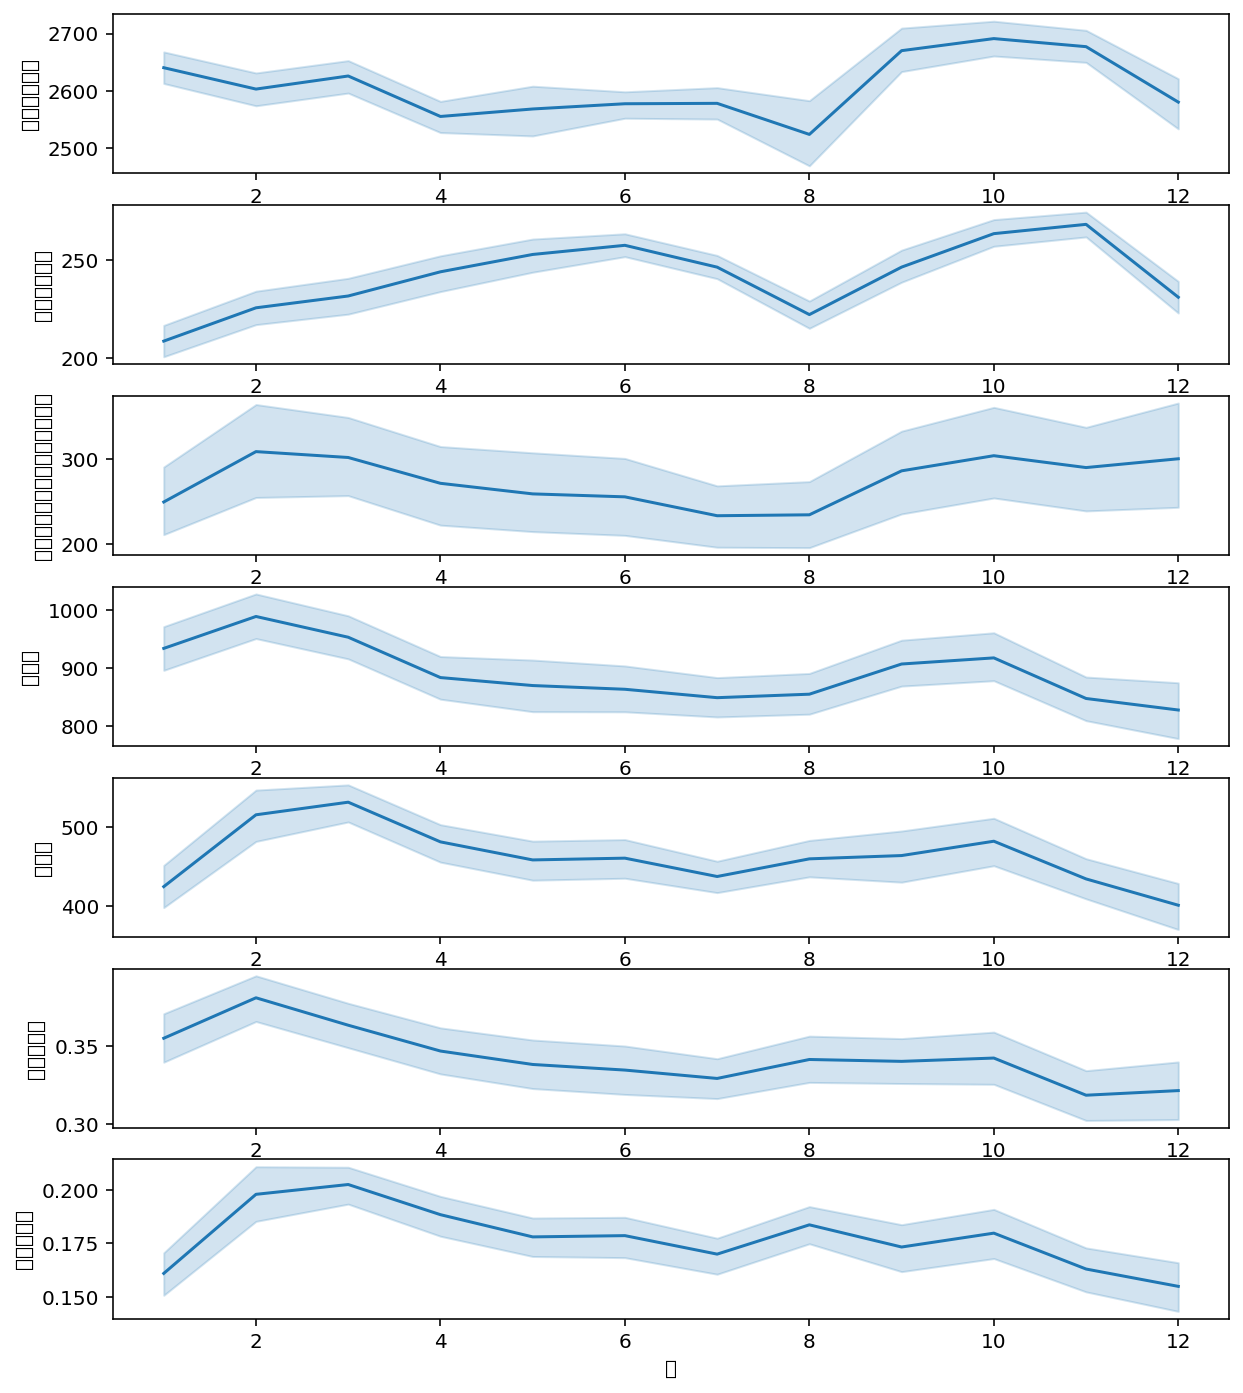

In [24]:
# 월을 중심으로 그래프 그리기

fig, ax = plt.subplots(7)
fig.set_size_inches(10,12)

sns.lineplot(data=train, x='월', y='식사가능자수', ax=ax[0])
sns.lineplot(data=train, x='월', y='본사출장자수', ax=ax[1])
sns.lineplot(data=train, x='월', y='본사시간외근무명령서승인건수', ax=ax[2])
sns.lineplot(data=train, x='월', y='중식계', ax=ax[3])
sns.lineplot(data=train, x='월', y='석식계', ax=ax[4])
sns.lineplot(data=train, x='월', y='중식참여율', ax=ax[5])
sns.lineplot(data=train, x='월', y='석식참여율', ax=ax[6])

월별 데이터에서

- 중식계와 석식계는 큰 차이가 없지만, 2,3월, 9,10월은 식수인원이 많은 걸로 보여진다

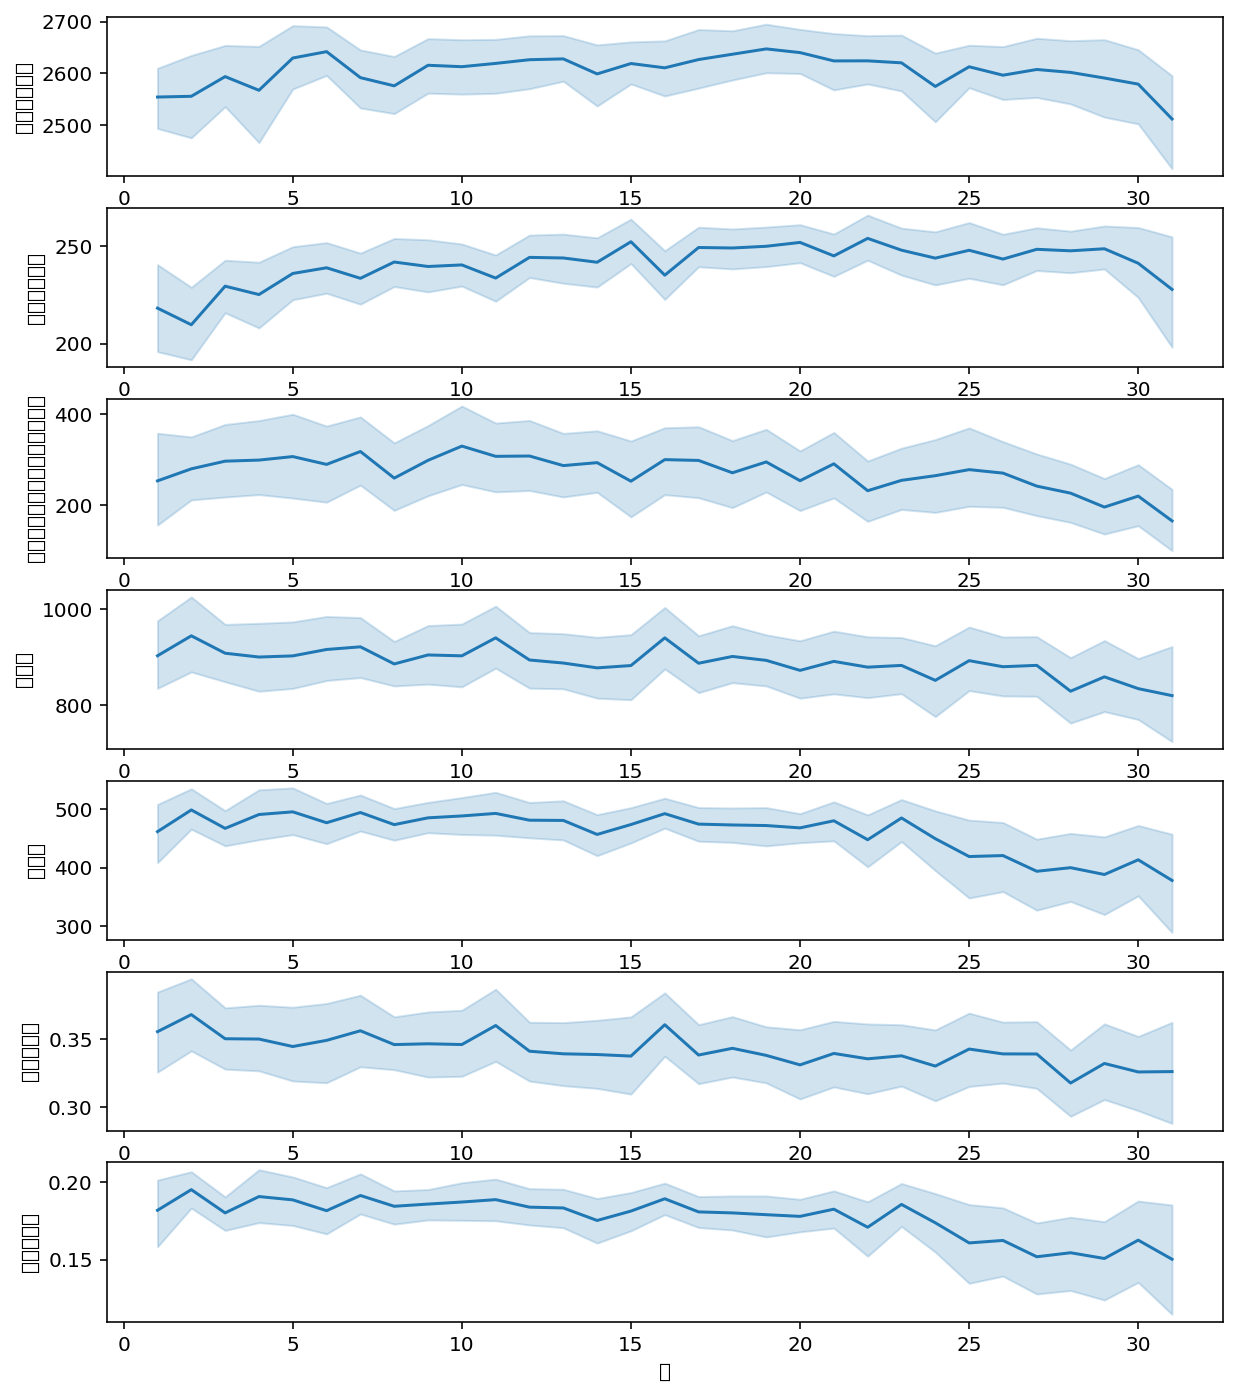

In [25]:
# 일을 중심으로 그래프 그리기

fig, ax = plt.subplots(7)
fig.set_size_inches(10,12)

sns.lineplot(data=train, x='일', y='식사가능자수', ax=ax[0])
sns.lineplot(data=train, x='일', y='본사출장자수', ax=ax[1])
sns.lineplot(data=train, x='일', y='본사시간외근무명령서승인건수', ax=ax[2])
sns.lineplot(data=train, x='일', y='중식계', ax=ax[3])
sns.lineplot(data=train, x='일', y='석식계', ax=ax[4])
sns.lineplot(data=train, x='일', y='중식참여율', ax=ax[5])
sns.lineplot(data=train, x='일', y='석식참여율', ax=ax[6])

일별 데이터는 각 컬럼의 상관관계가 크지 않은 것으로 볼 수 있다

In [26]:
# 요일을 석식 rank에 맞춰 mapping한 요일(석식) 칼럼 만들기.

weekday_rank4dinner = {
    1: 1,
    2: 2,
    3: 5,
    4: 3,
    5: 4,
}

train['요일(석식)'] = train['요일'].map(weekday_rank4dinner)
test['요일(석식)'] = test['요일'].map(weekday_rank4dinner)

In [27]:
train.head()

,월,일,요일,식사가능자수,본사출장자수,본사시간외근무명령서승인건수,중식계,석식계,중식참여율,석식참여율,요일(석식)
0,2,1,1,2551.0,150,238,1039.0,331.0,0.407291,0.129753,1
1,2,2,2,2551.0,173,319,867.0,560.0,0.339867,0.219522,2
2,2,3,3,2545.0,180,111,1017.0,573.0,0.399607,0.225147,5
3,2,4,4,2497.0,220,355,978.0,525.0,0.391670,0.210252,3
4,2,5,5,2323.0,181,34,925.0,330.0,0.398192,0.142058,4


## 모델 만들기

In [28]:
#제출용 데이터 가져오기

submit = pd.read_csv('/content/drive/MyDrive/구내식당AI/sample_submission.csv')
submit.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


In [29]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from lightgbm import LGBMRegressor

# 과적합을 방지하기 위해 KFold 사용
kfold = KFold(n_splits=5, shuffle=True)

# LightGBM Regressor 사용
lgbmr = LGBMRegressor()

# 파라미터들 dict 형태로 정의
param = {
    'max_depth': [10, 20, -1], # 트리의 최대 깊이  / 과적합 제어
    'learning_rate': [0.1, 0.05], # 학습률
    'num_leaves': [64,128, 196], # 각 트리가 가질 수 있는 최대 리프의 개수 / 정확도 및 복잡률과 비례
    'n_estimators': [2000, 3000], # 반복 수행하는 트리의 개수
    }

# RandomizedSearchCV를 사용해 하이퍼 파라미터 최적화
lunch_model = RandomizedSearchCV(lgbmr, # 사용 모델
                                scoring='r2', # 학습에 사용할 손실 함수
                                n_iter=20, # 파라미터별 학습 수
                                param_distributions=param, # 파라미터
                                cv=kfold, # 폴드 값에 KFold 객체 할당
                                return_train_score=True, # 학습 결과 리턴
                                verbose=2)

x = train[['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y = train['중식계']

# GridSearch 하면서 모든 파라미터값들에 대해 학습 수행
lunch_model.fit(x, y)
print(lunch_model.best_score_, lunch_model.best_params_)
lunch_model = lunch_model.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] num_leaves=128, n_estimators=3000, max_depth=20, learning_rate=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  num_leaves=128, n_estimators=3000, max_depth=20, learning_rate=0.1, total=   2.6s
[CV] num_leaves=128, n_estimators=3000, max_depth=20, learning_rate=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  num_leaves=128, n_estimators=3000, max_depth=20, learning_rate=0.1, total=   2.6s
[CV] num_leaves=128, n_estimators=3000, max_depth=20, learning_rate=0.1 
[CV]  num_leaves=128, n_estimators=3000, max_depth=20, learning_rate=0.1, total=   2.6s
[CV] num_leaves=128, n_estimators=3000, max_depth=20, learning_rate=0.1 
[CV]  num_leaves=128, n_estimators=3000, max_depth=20, learning_rate=0.1, total=   2.6s
[CV] num_leaves=128, n_estimators=3000, max_depth=20, learning_rate=0.1 
[CV]  num_leaves=128, n_estimators=3000, max_depth=20, learning_rate=0.1, total=   2.5s
[CV] num_leaves=196, n_estimators=2000, max_depth=10, learning_rate=0.05 
[CV]  num_leaves=196, n_estimators=2000, max_depth=10, learning_rate=0.05, total=   1.1s
[CV] num_leaves=196, n_estimators=2000, max_depth=10, learning_rate=0.05 
[CV]  num_leaves=196, n_estimators=2000, max_depth=10, learning_rate=0.05, total=   1.1s
[CV] num_leaves=196, n_estimators=2000, max_depth=10, learning_rate=0.05 
[CV]  num_leaves=196, n_estim

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.3min finished


0.7138194717813959 {'num_leaves': 196, 'n_estimators': 2000, 'max_depth': 10, 'learning_rate': 0.05}


In [30]:
#모델 적용시켜 예측하기

test_x = test[['월', '일', '요일', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y_pred = lunch_model.predict(test_x)

In [31]:
print(y_pred)

[1094.30314557 1055.31790366  508.84817702 1208.13880352  979.03087189
 1093.30475923  982.04357215  698.6250346  1248.00663149 1088.08548277
  874.71777792 1411.21458577 1148.58248359 1185.23249143  907.19229436
  745.9733428  1280.33993749 1028.6904104   875.81132686  957.83212987
  636.85991889 1072.20491485 1100.48800356 1001.92354606  619.99259376
 1286.68649918 1048.8314301  1067.16163735 1073.77421044  625.23341344
 1321.72090073 1017.01289973 1180.3177598   918.58680742  653.96777643
 1264.32372881  875.52187217 1004.42122604  934.96089179  624.40453799
 1262.32306036  986.25468551 1064.2681485   908.17092167  644.8143271
 1236.79052418 1062.81900468 1093.16463393  985.67646274  617.21570823]


In [32]:
submit['중식계'] = y_pred

In [33]:
lgbmr = LGBMRegressor()

# 파라미터들 dict 형태로 정의
param = {
    'max_depth': [10, 20, -1], # 트리의 최대 깊이  / 과적합 제어
    'learning_rate': [0.1, 0.05], # 학습률
    'num_leaves': [64,128, 196], # 각 트리가 가질 수 있는 최대 리프의 개수 / 정확도 및 복잡률과 비례
    'n_estimators': [2000, 3000], # 반복 수행하는 트리의 개수
    }

# RandomizedSearchCV를 사용해 하이퍼 파라미터 최적화
dinner_model = RandomizedSearchCV(lgbmr, # 사용 모델
                                scoring='r2', # 학습에 사용할 손실 함수
                                n_iter=20, # 파라미터별 학습 수
                                param_distributions=param, # 파라미터
                                cv=kfold, # 폴드 값에 KFold 객체 할당
                                return_train_score=True, # 학습 결과 리턴
                                verbose=2)

x = train[['월', '일', '요일(석식)', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y = train['석식계']

# GridSearch 하면서 모든 파라미터값들에 대해 학습 수행
dinner_model.fit(x, y)
print(dinner_model.best_score_, dinner_model.best_params_)
dinner_model = dinner_model.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] num_leaves=196, n_estimators=3000, max_depth=20, learning_rate=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  num_leaves=196, n_estimators=3000, max_depth=20, learning_rate=0.1, total=   2.5s
[CV] num_leaves=196, n_estimators=3000, max_depth=20, learning_rate=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  num_leaves=196, n_estimators=3000, max_depth=20, learning_rate=0.1, total=   2.4s
[CV] num_leaves=196, n_estimators=3000, max_depth=20, learning_rate=0.1 
[CV]  num_leaves=196, n_estimators=3000, max_depth=20, learning_rate=0.1, total=   2.4s
[CV] num_leaves=196, n_estimators=3000, max_depth=20, learning_rate=0.1 
[CV]  num_leaves=196, n_estimators=3000, max_depth=20, learning_rate=0.1, total=   2.4s
[CV] num_leaves=196, n_estimators=3000, max_depth=20, learning_rate=0.1 
[CV]  num_leaves=196, n_estimators=3000, max_depth=20, learning_rate=0.1, total=   2.4s
[CV] num_leaves=64, n_estimators=3000, max_depth=-1, learning_rate=0.05 
[CV]  num_leaves=64, n_estimators=3000, max_depth=-1, learning_rate=0.05, total=   2.4s
[CV] num_leaves=64, n_estimators=3000, max_depth=-1, learning_rate=0.05 
[CV]  num_leaves=64, n_estimators=3000, max_depth=-1, learning_rate=0.05, total=   2.3s
[CV] num_leaves=64, n_estimators=3000, max_depth=-1, learning_rate=0.05 
[CV]  num_leaves=64, n_estimators=

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.4min finished


0.5189229981315501 {'num_leaves': 64, 'n_estimators': 2000, 'max_depth': -1, 'learning_rate': 0.1}


In [34]:
#모델 적용시켜 예측하기

test_x = test[['월', '일', '요일(석식)', '식사가능자수', '본사출장자수', '본사시간외근무명령서승인건수']]
y_pred = dinner_model.predict(test_x)

In [35]:
submit['석식계'] = y_pred

In [39]:
#예측한 모델결과 저장하기

submit.to_csv('/content/drive/MyDrive/구내식당AI/LGBM_submit.csv', index=False)

from google.colab import files

files.download('/content/drive/MyDrive/구내식당AI/LGBM_submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

결과 70.15078점

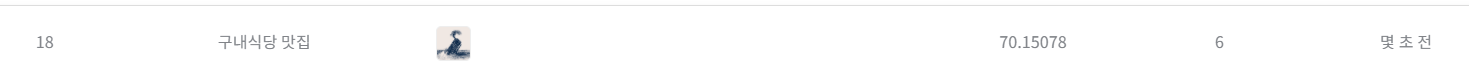